# HOMEWORK 5: TEXT CLASSIFICATION
In this homework, you will create models to classify texts from TRUE call-center. There are two classification tasks:
1. Action Classification: Identify which action the customer would like to take (e.g. enquire, report, cancle)
2. Object Classification: Identify which object the customer is referring to (e.g. payment, truemoney, internet, roaming) 

In this homework, you are asked to do the following tasks:
1. Data Cleaning
2. Preprocessing data for keras
3. Build and evaluate a model for "action" classification
4. Build and evaluate a model for "object" classification
5. Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 


Note: we have removed phone numbers from the dataset for privacy purposes. 

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import shutil
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/clean-phone-data.csv", "/content/clean-phone-data.csv")

## Import Libs

In [3]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt

## Loading data
First, we load the data from disk into a Dataframe.

A Dataframe is essentially a table, or 2D-array/Matrix with a name for each column.

In [4]:
phone_df = pandas.read_csv('data/hw3_1/clean-phone-data.csv')

Let's preview the data.

In [5]:
# Show the top 5 rows
display(phone_df.head())
# Summarize the data
phone_df.describe()

,Sentence Utterance,Action,Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues


,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


## Data cleaning

We call the DataFrame.describe() again.
Notice that there are 33 unique labels/classes for object and 10 unique labels for action that the model will try to predict.
But there are unwanted duplications e.g. Idd,idd,lotalty_card,Lotalty_card

Also note that, there are 13389 unqiue sentence utterances from 16175 utterances. You have to clean that too!

## #TODO 1: 
You will have to remove unwanted label duplications as well as duplications in text inputs. 
Also, you will have to trim out unwanted whitespaces from the text inputs. 
This shouldn't be too hard, as you have already seen it in the demo.



In [6]:
display(phone_df.describe())
display(phone_df.Object.unique())
display(phone_df.Action.unique())

,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

array(['enquire', 'report', 'cancel', 'Enquire', 'buy', 'activate',
       'request', 'Report', 'garbage', 'change'], dtype=object)

### **Remove unwanted label duplications**

In [7]:
df_phone = phone_df.copy()

In [8]:
df_phone['Object_clean'] = df_phone['Object'].str.lower().copy()
df_phone['Action_clean'] = df_phone['Action'].str.lower().copy()
display(df_phone.describe())
display(df_phone.Object_clean.unique())
display(df_phone.Action_clean.unique())

,Sentence Utterance,Action,Object,Object_clean,Action_clean
count,16175,16175,16175,16175,16175
unique,13389,10,33,26,8
top,บริการอื่นๆ,enquire,service,service,enquire
freq,97,10377,2525,2528,10484


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nontruemove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd', 'garbage',
       'ringtone', 'rate', 'loyalty_card', 'contact', 'officer'],
      dtype=object)

array(['enquire', 'report', 'cancel', 'buy', 'activate', 'request',
       'garbage', 'change'], dtype=object)

In [9]:
df_phone.drop(['Object', 'Action'], axis=1, inplace=True)
df_phone.rename(columns={'Object_clean': 'Object', 'Action_clean': 'Action','Sentence Utterance': 'Sentence'}, inplace=True)

### **Remove Duplications in text inputs**

In [10]:
display(df_phone.describe())

,Sentence,Object,Action
count,16175,16175,16175
unique,13389,26,8
top,บริการอื่นๆ,service,enquire
freq,97,2528,10484


In [11]:
idx = df_phone[df_phone['Sentence'] == 'บริการอื่นๆ'].index
# Show duplicate sentences
display(df_phone.loc[idx])

,Sentence,Object,Action
13676,บริการอื่นๆ,service,enquire
13683,บริการอื่นๆ,service,enquire
13765,บริการอื่นๆ,service,enquire
13853,บริการอื่นๆ,service,enquire
13871,บริการอื่นๆ,service,enquire
...,...,...,...
16010,บริการอื่นๆ,service,enquire
16023,บริการอื่นๆ,service,enquire
16060,บริการอื่นๆ,service,enquire
16115,บริการอื่นๆ,service,enquire


In [12]:
df_phone = df_phone.drop_duplicates("Sentence",keep='first')
display(df_phone.describe())

,Sentence,Object,Action
count,13389,13389,13389
unique,13389,26,8
top,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,service,enquire
freq,1,2111,8658


### **Remove unwanted whitespaces**

In [13]:
def strip_space(text):
    return text.strip()

df_phone['Sentence'] = df_phone['Sentence'].apply(strip_space)
df_phone.head()

,Sentence,Object,Action
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter...,payment,enquire
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,package,enquire
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ,suspend,report
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,internet,enquire
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...,phone_issues,report


### **Remove html tags**

In [14]:
import re

html_tag_pattern = r'<[^>]+>'
def remove_html_tags(text):
    return re.sub(html_tag_pattern, '', text)

df_phone['Sentence_<remove>'] = df_phone['Sentence'].apply(remove_html_tags)
html_tag_idx = df_phone[df_phone['Sentence_<remove>'] != df_phone['Sentence']].index
display(df_phone.loc[html_tag_idx])

,Sentence,Object,Action,Sentence_<remove>
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter...,payment,enquire,ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 327...
6,<PHONE_NUMBER_REMOVED> เคยมีช่างมาซ่อมที่บ้าน ...,nontruemove,enquire,เคยมีช่างมาซ่อมที่บ้าน แล้วโทรศัพท์ใช้งานไม่ไ...
7,<PHONE_NUMBER_REMOVED> ค้างค่าบริการเท่าไหร่ครับ,balance,enquire,ค้างค่าบริการเท่าไหร่ครับ
8,<PHONE_NUMBER_REMOVED> อินเตอร์เน็ตไฟ Adsl ไม่...,nontruemove,enquire,อินเตอร์เน็ตไฟ Adsl ไม่มีสัญญาณครับ
9,<PHONE_NUMBER_REMOVED> เค้าบอกจะส่งรหัสเน็ตมาใ...,internet,enquire,เค้าบอกจะส่งรหัสเน็ตมาให้ แต่ยังไม่ได้ส่งมาเล...
...,...,...,...,...
13358,อยากสอบถามว่าเบอร์ '<PHONE_NUMBER_REMOVED> โดน...,payment,enquire,อยากสอบถามว่าเบอร์ ' โดนตัดไปหรือยังค่ะ เนื่อง...
13547,ฮัลโล ทรูน่ะครับผม เบอร์ <PHONE_NUMBER_REMOVED...,nontruemove,enquire,ฮัลโล ทรูน่ะครับผม เบอร์ ครับดูจากประวัติคงทร...
13572,ฮัลโหลครับ ช่วยเช็คสัญญาณอินเตอร์เน็ตเบอร์ <PH...,internet,enquire,ฮัลโหลครับ ช่วยเช็คสัญญาณอินเตอร์เน็ตเบอร์ ให...
13601,ฮัลโหลค่ะพี่ พี่ช่วยเช็คเบอร์ <PHONE_NUMBER_RE...,balance,enquire,ฮัลโหลค่ะพี่ พี่ช่วยเช็คเบอร์ ว่าเน็ตมันหมดมั...


In [15]:
df_phone.drop(['Sentence'], axis=1, inplace=True)
df_phone.rename(columns={'Sentence_<remove>': 'Sentence'}, inplace=True)
display(df_phone.head())

,Object,Action,Sentence
0,payment,enquire,ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 327...
1,package,enquire,internet ยังความเร็วอยุ่เท่าไหร ครับ
2,suspend,report,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
3,internet,enquire,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...
4,phone_issues,report,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...


### **English lowercase**

In [16]:
eng_char = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
def check_eng_char(text):
    for char in text:
        if char in eng_char:
            return True
    return False

df_phone['Eng'] = df_phone['Sentence'].apply(check_eng_char)
eng_idx = df_phone[df_phone['Eng'] == True].index
display(df_phone.loc[eng_idx])

,Object,Action,Sentence,Eng
0,payment,enquire,ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 327...,True
1,package,enquire,internet ยังความเร็วอยุ่เท่าไหร ครับ,True
3,internet,enquire,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,True
8,nontruemove,enquire,อินเตอร์เน็ตไฟ Adsl ไม่มีสัญญาณครับ,True
21,internet,enquire,มีการเปิดใช้งาน GPRS หรือป่าว,True
...,...,...,...,...
13618,mobile_setting,enquire,ฮาโหลครับ คือผม ผมเปลี่ยนจากทรูมูฟเป็นทรูมูฟเอ...,True
13624,rate,enquire,ฮาโหลครับ ผมสอบถามนิดนึงครับ คือผมจะตั้งให้อีเ...,True
13625,package,buy,ฮาโหลครับ สมัคร Buffet ทรูมูฟ กดอะไรครับ,True
13629,phone_issues,report,ฮาโหลค่ะ เพิ่งซื้อ Goal live มาแล้วโทรออกไม่ได...,True


In [17]:
def lower_case(text):
    return text.lower()

df_phone['Sentence'] = df_phone['Sentence'].apply(lower_case)
display(df_phone.loc[eng_idx])

,Object,Action,Sentence,Eng
0,payment,enquire,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...,True
1,package,enquire,internet ยังความเร็วอยุ่เท่าไหร ครับ,True
3,internet,enquire,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,True
8,nontruemove,enquire,อินเตอร์เน็ตไฟ adsl ไม่มีสัญญาณครับ,True
21,internet,enquire,มีการเปิดใช้งาน gprs หรือป่าว,True
...,...,...,...,...
13618,mobile_setting,enquire,ฮาโหลครับ คือผม ผมเปลี่ยนจากทรูมูฟเป็นทรูมูฟเอ...,True
13624,rate,enquire,ฮาโหลครับ ผมสอบถามนิดนึงครับ คือผมจะตั้งให้อีเ...,True
13625,package,buy,ฮาโหลครับ สมัคร buffet ทรูมูฟ กดอะไรครับ,True
13629,phone_issues,report,ฮาโหลค่ะ เพิ่งซื้อ goal live มาแล้วโทรออกไม่ได...,True


In [18]:
df_phone.drop(['Eng'], axis=1, inplace=True)
display(df_phone.head())

,Object,Action,Sentence
0,payment,enquire,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...
1,package,enquire,internet ยังความเร็วอยุ่เท่าไหร ครับ
2,suspend,report,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
3,internet,enquire,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...
4,phone_issues,report,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...


### **Label Mapping**

In [19]:
def get_label_map(df, col_name):
    label_map = {}
    for i, label in enumerate(df[col_name].unique()):
        label_map[label] = i
    reversed_label_map = {v: k for k, v in label_map.items()}
    return label_map, reversed_label_map

object_label_map, object_reversed_label_map = get_label_map(df_phone, 'Object')
display(object_label_map)

{'payment': 0,
 'package': 1,
 'suspend': 2,
 'internet': 3,
 'phone_issues': 4,
 'service': 5,
 'nontruemove': 6,
 'balance': 7,
 'detail': 8,
 'bill': 9,
 'credit': 10,
 'promotion': 11,
 'mobile_setting': 12,
 'iservice': 13,
 'roaming': 14,
 'truemoney': 15,
 'information': 16,
 'lost_stolen': 17,
 'balance_minutes': 18,
 'idd': 19,
 'garbage': 20,
 'ringtone': 21,
 'rate': 22,
 'loyalty_card': 23,
 'contact': 24,
 'officer': 25}

In [20]:
action_label_map, action_reversed_label_map = get_label_map(df_phone, 'Action')
display(action_label_map)

{'enquire': 0,
 'report': 1,
 'cancel': 2,
 'buy': 3,
 'activate': 4,
 'request': 5,
 'garbage': 6,
 'change': 7}

In [21]:
df_phone['Object'] = df_phone['Object'].map(object_label_map)
df_phone['Action'] = df_phone['Action'].map(action_label_map)
display(df_phone.head())

,Object,Action,Sentence
0,0,0,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...
1,1,0,internet ยังความเร็วอยุ่เท่าไหร ครับ
2,2,1,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
3,3,0,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...
4,4,1,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...


In [22]:
display(df_phone.Object.unique())
display(df_phone.Action.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

### **Copy data**

In [23]:
df_action = df_phone.copy()[['Sentence', 'Action']]
display(df_action.head())

,Sentence,Action
0,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...,0
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,0
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ,1
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,0
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...,1


In [24]:
df_object = df_phone.copy()[['Sentence', 'Object']]
display(df_object.head())

,Sentence,Object
0,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...,0
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,1
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ,2
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,3
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...,4


In [25]:
df_all = df_phone.copy()
display(df_all.head())

,Object,Action,Sentence
0,0,0,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...
1,1,0,internet ยังความเร็วอยุ่เท่าไหร ครับ
2,2,1,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
3,3,0,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...
4,4,1,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...


## #TODO 2: Preprocessing data for Keras
You will be using Tensorflow 2 keras in this assignment. Please show us how you prepare your data for keras.
Don't forget to split data into train and test sets (+ validation set if you want)

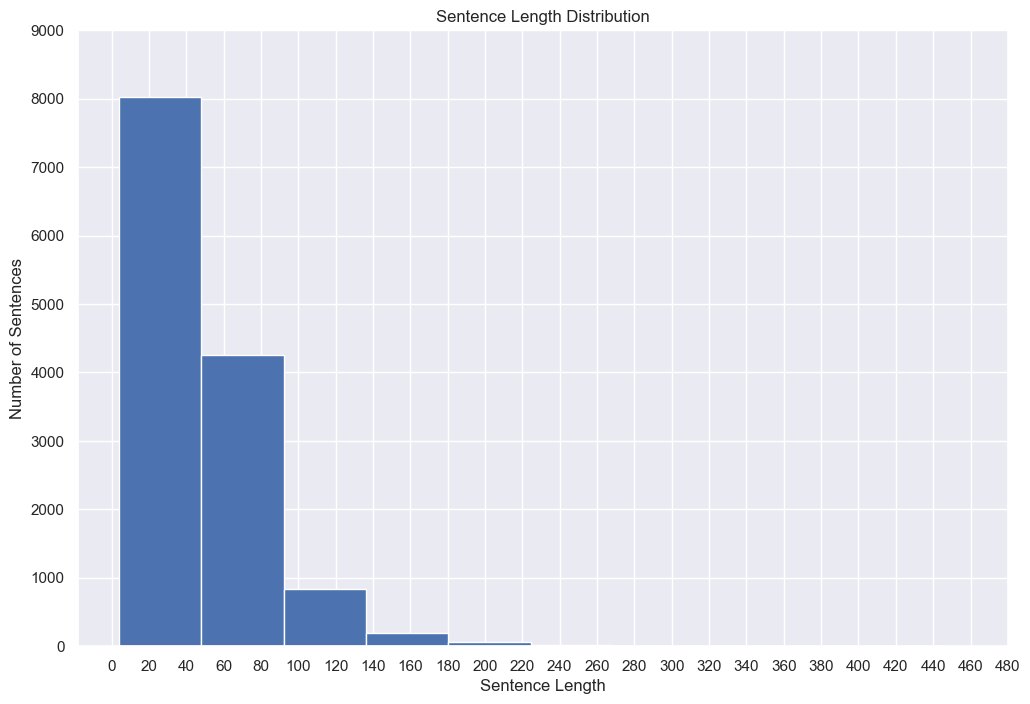

In [26]:
# Plot sentence length distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set(font_scale=1.0)
plt.rcParams['figure.figsize'] = (12, 8)
 
def plot_sentence_length_distribution(df, col_name):
    df[col_name].apply(len).hist()
    plt.title('Sentence Length Distribution')
    plt.xlabel('Sentence Length')
    plt.ylabel('Number of Sentences')
    plt.yticks(np.arange(0, 10000, 1000))
    plt.xticks(np.arange(0, 500, 20))
    plt.show()
 
plot_sentence_length_distribution(df_all, 'Sentence')

In [27]:
print('Max sentence length:', df_all['Sentence'].apply(len).max())

Max sentence length: 445


In [28]:
# Remove sentence with length > 200
df_all = df_all[df_all['Sentence'].apply(len) <= 200]
print(f'Removed {round((1 - len(df_all) / len(df_phone)) * 100, 2)}% of sentences')
print('Remaining sentences:', len(df_all))
print('Max sentence length:', df_all['Sentence'].apply(len).max())

Removed 0.39% of sentences
Remaining sentences: 13337
Max sentence length: 200


In [29]:
print('Max sentence length:', df_all['Sentence'].apply(len).max())
max_len_sentence_idx = df_all['Sentence'].apply(len).idxmax()
print(f'is this sentence: \n{df_all["Sentence"][max_len_sentence_idx]}')

Max sentence length: 200
is this sentence: 
จะซื้อ นิวส์ไอแพด พอดีเห็นโปรฯ หน้าเว็บ แจ้งว่าหากใช้บัตร ทรูการ์ดจะได้ส่วนลดค่าเครื่อง 2000 บาท ตรงนี้หมดเขตเมื่อไรครับ ส่วนลดค่าเครื่อง 2000 บาทใช้ได้ถึงเมื่อไรครับ แล้วใช้ได้กับเครื่องทุกรุ่นเลยไหม


In [30]:
df_all

,Object,Action,Sentence
0,0,0,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...
1,1,0,internet ยังความเร็วอยุ่เท่าไหร ครับ
2,2,1,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
3,3,0,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...
4,4,1,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...
...,...,...,...
16167,9,0,ต้องการทราบวันตัดรอบบิลค่ะ
16170,3,0,เชื่อมต่ออินเตอร์เน็ตไม่ได้ค่ะ
16172,7,0,ยอดเงินเหลือเท่าไหร่ค่ะ
16173,7,0,ยอดเงินในระบบ


### **Tokenize**

In [31]:
# Text tokenization
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

def get_tokenizer(df, col_name, num_words):
    tokenizer = Tokenizer(num_words=num_words, oov_token='<UNK>')
    tokenizer.fit_on_texts(df[col_name])
    return tokenizer

def get_sequence(tokenizer, df, col_name, max_len):
    sequences = tokenizer.texts_to_sequences(df[col_name])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post', dtype='int32', value=0.)
    return padded_sequences

def get_label(df, col_name):
    return np.array(df[col_name])

def get_vocab_size(tokenizer):
    return len(tokenizer.word_index) + 1

def get_max_len(df, col_name):
    return max(df[col_name].apply(len))

Tokenizer = get_tokenizer(df_all, 'Sentence', 10000)
vocab_size = get_vocab_size(Tokenizer)
max_len = get_max_len(df_all, 'Sentence')
print('Vocab size:', vocab_size)
print('Max length:', max_len)
text_sequences = get_sequence(Tokenizer, df_all, 'Sentence', max_len)

Vocab size: 23764
Max length: 200


In [32]:
print('Text sequences shape:', text_sequences.shape)
print('Text sequences:')
print(text_sequences)

Text sequences shape: (13337, 200)
Text sequences:
[[2268 2269  726 ...    0    0    0]
 [   6 2274    3 ...    0    0    0]
 [2275  727    2 ...    0    0    0]
 ...
 [   1    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]]


In [33]:
word_index = Tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_maped = {v: k for k, v in word_index.items()}
data_maped[0] = '<PAD>'
def map_encoded_to_word(encoded):
    return [data_maped[word] for word in encoded]
print(f'Encoded: {text_sequences[0][:14]}')
print(f'Decoded: {map_encoded_to_word(text_sequences[0][:14])}')

Found 23763 unique tokens.
Encoded: [2268 2269  726 2270 2271  248    8 2272 2273  309    8    0    0    0]
Decoded: ['ผมไปจ่ายเงินที่', 'counter', 'services', 'เค้าเช็ต', '3276', '25', 'บาท', 'เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด', '3057', '79', 'บาท', '<PAD>', '<PAD>', '<PAD>']


### **Vectorize**

In [34]:
# Text vectorization
# import tensorflow as tf
# import string
# from keras.layers import TextVectorization

In [35]:
# # Set the parameters for the vectorization layer
# batch_size = 128

In [36]:
# # Set the parameters for the vectorization layer
# max_features = 10000
# sequence_length = 100
# batch_size = 128

# def custom_standardization(input_data):
#   lowercase = tf.strings.lower(input_data)
#   stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
#   return tf.strings.regex_replace(stripped_html,
#                                   '[%s]' % re.escape(string.punctuation),
#                                   '')

# # Create the text vectorization layer
# vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     max_tokens=max_features,
#     output_mode='int',
#     output_sequence_length=sequence_length)

### **Split data**

In [37]:
random_state = 42
np.random.seed(random_state)

In [38]:
print('Text sequences shape:', text_sequences.shape)
object_labels = get_label(df_all, 'Object')
action_labels = get_label(df_all, 'Action')
print('Object labels shape:', object_labels.shape)
print('Action labels shape:', action_labels.shape)

Text sequences shape: (13337, 200)
Object labels shape: (13337,)
Action labels shape: (13337,)


In [ ]:
text_data_with_label = [{'text': text_sequences[i],
                         'object_label': object_labels[i],
                          'action_label': action_labels[i]} 
                          for i in range(len(text_sequences))]

In [ ]:
# Split data into train, validation, and test sets
from sklearn.model_selection import train_test_split

def split_data(data, lable, test_size=0.2, val_size=0.2):
    train_data, test_data, train_labels, test_labels = train_test_split(data, lable, test_size=test_size, random_state=random_state, shuffle=False)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_size, random_state=random_state, shuffle=False)
    return train_data, train_labels, val_data, val_labels, test_data, test_labels

train, val, test = split_data(text_sequences)

In [ ]:
print('Train shape:', train.shape)
print('Validation shape:', val.shape)
print('Test shape:', test.shape)

## #TODO 3: Build and evaluate a model for "action" classification


In [ ]:
#TODO 3: Build and evaluate a model for "action" classification

In [ ]:
def get_model(vocab_size, max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length=max_len))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## #TODO 4: Build and evaluate a model for "object" classification



In [ ]:
#TODO 4: Build and evaluate a model for "object" classification

## #TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 

This can be a bit tricky, if you are not familiar with the Keras functional API. PLEASE READ these webpages(https://www.tensorflow.org/guide/keras/functional, https://keras.io/getting-started/functional-api-guide/) before you start this task.   

Your model will have 2 separate output layers one for action classification task and another for object classification task. 

This is a rough sketch of what your model might look like:
image --> https://drive.google.com/file/d/1r7M6tFyQDu6pJIxLd_fn2kBMjo_CWmUK/view?usp=share_link

![Rough Sketch](pic/HW3-1_multitask_sketch.png)

In [ ]:
#TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go